
Training on Cora dataset with neighbor sample size: 1 and aggregation: mean...
Early stopping triggered at epoch 41.
Aggregation: mean, Neighbor Sample Size: 1, Time Taken: 9.48 seconds, Best Test F1: 0.8030

Training on Cora dataset with neighbor sample size: 2 and aggregation: mean...
Early stopping triggered at epoch 45.
Aggregation: mean, Neighbor Sample Size: 2, Time Taken: 10.43 seconds, Best Test F1: 0.8000

Training on Cora dataset with neighbor sample size: 3 and aggregation: mean...
Early stopping triggered at epoch 45.
Aggregation: mean, Neighbor Sample Size: 3, Time Taken: 9.60 seconds, Best Test F1: 0.7880

Training on Cora dataset with neighbor sample size: 4 and aggregation: mean...
Early stopping triggered at epoch 45.
Aggregation: mean, Neighbor Sample Size: 4, Time Taken: 10.14 seconds, Best Test F1: 0.8020

Training on Cora dataset with neighbor sample size: 5 and aggregation: mean...
Early stopping triggered at epoch 31.
Aggregation: mean, Neighbor Sample Size: 5, 

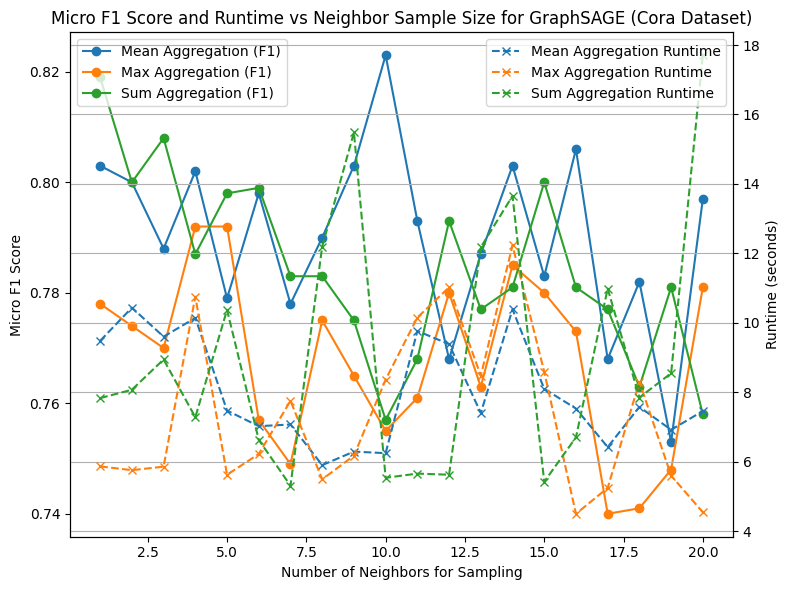

In [ ]:
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader
from torch.optim import Adam
from sklearn.metrics import f1_score


# Load Cora dataset
def load_cora_dataset():
    dataset = Planetoid(root="./data", name="Cora")
    return dataset


# GraphSAGE Model (Supervised Learning) with Aggregation Type as a Parameter
class GraphSAGE(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_layers,
        dropout,
        aggr_type="mean",
    ):
        super().__init__()
        self.aggr_type = aggr_type
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels, aggr=self.aggr_type))
        for _ in range(num_layers - 2):
            self.convs.append(
                SAGEConv(hidden_channels, hidden_channels, aggr=self.aggr_type)
            )
        self.convs.append(SAGEConv(hidden_channels, out_channels, aggr=self.aggr_type))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x


# Training function using NeighborLoader
def train(loader, model, optimizer, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = F.cross_entropy(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


# Evaluation function using micro F1 score
def evaluate(model, data, mask, device):
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), data.edge_index.to(device))
        pred = out.argmax(dim=1)
        true_labels = data.y[mask].to(device).cpu().numpy()
        pred_labels = pred[mask].cpu().numpy()
        f1 = f1_score(true_labels, pred_labels, average="micro")
        return f1


# Training and evaluation loop with early stopping
def train_with_early_stopping(
    dataset, neighbor_sample_size, aggr_type, epochs=1000, patience=25, batch_size=128
):
    device = torch.device("cpu")  # Use CPU
    print(
        f"\nTraining on Cora dataset with neighbor sample size: {neighbor_sample_size} and aggregation: {aggr_type}..."
    )

    data = dataset[0]

    # NeighborLoader for training
    train_loader = NeighborLoader(
        data,
        num_neighbors=[neighbor_sample_size] * 2,  # Sample neighbors for each layer
        input_nodes=data.train_mask,
        batch_size=batch_size,
        shuffle=True,
    )

    # Initialize model and optimizer
    model = GraphSAGE(
        in_channels=dataset.num_features,
        hidden_channels=64,
        out_channels=dataset.num_classes,
        num_layers=2,
        dropout=0.5,
        aggr_type=aggr_type,
    ).to(device)
    optimizer = Adam(model.parameters(), lr=0.01)

    # Early stopping variables
    best_val_f1 = 0
    best_test_f1 = 0
    patience_counter = 0

    for epoch in range(epochs):
        # Perform training
        loss = train(train_loader, model, optimizer, device)

        # Evaluate on training, validation, and test sets
        train_f1 = evaluate(model, data, data.train_mask, device)
        val_f1 = evaluate(model, data, data.val_mask, device)
        test_f1 = evaluate(model, data, data.test_mask, device)

        # Save the best validation F1 score and corresponding test F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_test_f1 = test_f1
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        # Check for early stopping based on validation set
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    return best_test_f1


# Train and evaluate on multiple neighbor sample sizes and aggregation functions
def plot_f1_score_vs_neighbor_samples():
    dataset = load_cora_dataset()
    neighbor_samples = list(range(1, 21))  # Vary the number of neighbors for sampling
    aggregations = ["mean", "max", "sum"]

    # Data structure to store results
    results = {"mean": [], "max": [], "sum": []}
    runtimes = {"mean": [], "max": [], "sum": []}

    # Run experiments for each aggregation function
    for aggr_type in aggregations:
        for neighbor_sample in neighbor_samples:
            start_time = time.time()  # Start timing for this neighbor sample size
            best_test_f1 = train_with_early_stopping(
                dataset, neighbor_sample, aggr_type
            )
            end_time = time.time()  # End timing after training

            runtime = end_time - start_time  # Calculate runtime for this training
            results[aggr_type].append(best_test_f1)
            runtimes[aggr_type].append(runtime)

            # Print runtime for each configuration
            print(
                f"Aggregation: {aggr_type}, Neighbor Sample Size: {neighbor_sample}, Time Taken: {runtime:.2f} seconds, Best Test F1: {best_test_f1:.4f}"
            )

    # Save the results to a CSV file
    results_df = pd.DataFrame(
        {
            "Neighbor Sample Size": neighbor_samples,
            "Mean Aggregation": results["mean"],
            "Max Aggregation": results["max"],
            "Sum Aggregation": results["sum"],
            "Mean Aggregation Runtime": runtimes["mean"],
            "Max Aggregation Runtime": runtimes["max"],
            "Sum Aggregation Runtime": runtimes["sum"],
        }
    )
    results_df.to_csv(
        "micro_f1_scores_vs_neighbor_samples_and_aggr_with_runtime.csv", index=False
    )
    print(
        "Results saved to 'micro_f1_scores_vs_neighbor_samples_and_aggr_with_runtime.csv'."
    )

    # Plot micro F1 score vs neighbor sample size for each aggregation function
    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.plot(
        neighbor_samples,
        results["mean"],
        marker="o",
        label="Mean Aggregation (F1)",
        color="tab:blue",
    )
    ax1.plot(
        neighbor_samples,
        results["max"],
        marker="o",
        label="Max Aggregation (F1)",
        color="tab:orange",
    )
    ax1.plot(
        neighbor_samples,
        results["sum"],
        marker="o",
        label="Sum Aggregation (F1)",
        color="tab:green",
    )
    ax1.set_xlabel("Number of Neighbors for Sampling")
    ax1.set_ylabel("Micro F1 Score")
    ax1.legend(loc="upper left")

    # Create a second y-axis for runtime
    ax2 = ax1.twinx()
    ax2.plot(
        neighbor_samples,
        runtimes["mean"],
        marker="x",
        label="Mean Aggregation Runtime",
        color="tab:blue",
        linestyle="--",
    )
    ax2.plot(
        neighbor_samples,
        runtimes["max"],
        marker="x",
        label="Max Aggregation Runtime",
        color="tab:orange",
        linestyle="--",
    )
    ax2.plot(
        neighbor_samples,
        runtimes["sum"],
        marker="x",
        label="Sum Aggregation Runtime",
        color="tab:green",
        linestyle="--",
    )
    ax2.set_ylabel("Runtime (seconds)")
    ax2.legend(loc="upper right")

    # Save the plot
    plt.title(
        "Micro F1 Score and Runtime vs Neighbor Sample Size for GraphSAGE (Cora Dataset)"
    )
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("micro_f1_score_and_runtime_vs_neighbor_samples_and_aggr.png")
    print(
        "Plot saved as 'micro_f1_score_and_runtime_vs_neighbor_samples_and_aggr.png'."
    )
    plt.show()


# Run the experiment
plot_f1_score_vs_neighbor_samples()
